## Introduction

> This data set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

> Our analysis will try to answer questions of how duration between booking and reservation and other factors affect reservation price. Further questions of price analysis will also be performed to find optimum independent parameters to find minimum dependent variable value, in this case, the booking price.

## Data Preparation for Regression - Feature: adr


In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from pandas.plotting import scatter_matrix

## Load & Cleanup Data

Read csv files without header included and show shape

### Load Data

In [15]:
df_hotel =pd.read_csv("hotel_bookings.csv", skiprows=0, header=0)
# storing data in backup for easy loading in next cell 
# (helps keep run context for each cell, so that they can be run independently)
df_hotel.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Feature Engineering
Adding calculated field, day number of the week and weekend. We believe there is a strong correlation between __arrival_weekday_num__ vs __is_canceled__, and __arrival_weekday_num__ and __adr__.

In [16]:
weekday = []
isWeekend = []
for index, row in df_hotel.iterrows():
    year = df_hotel['arrival_date_year'].iloc[index]
    month_name = df_hotel['arrival_date_month'].iloc[index]
    month_number = datetime.datetime.strptime(month_name, '%B').month
    dayOfMonth = df_hotel['arrival_date_day_of_month'].iloc[index]
    dayOfWeek = datetime.datetime(year,month_number,dayOfMonth).weekday()
    weekday.append(dayOfWeek)
    if (dayOfWeek>3):
        isWeekend.append(1)
    else:
        isWeekend.append(0)
       
df_hotel['arrival_weekday_num'] = weekday
df_hotel['arrival_day_is_weekend'] = isWeekend

df_hotel.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_weekday_num,arrival_day_is_weekend
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2,0


(-1.25, 1.25, -1.25, 1.25)

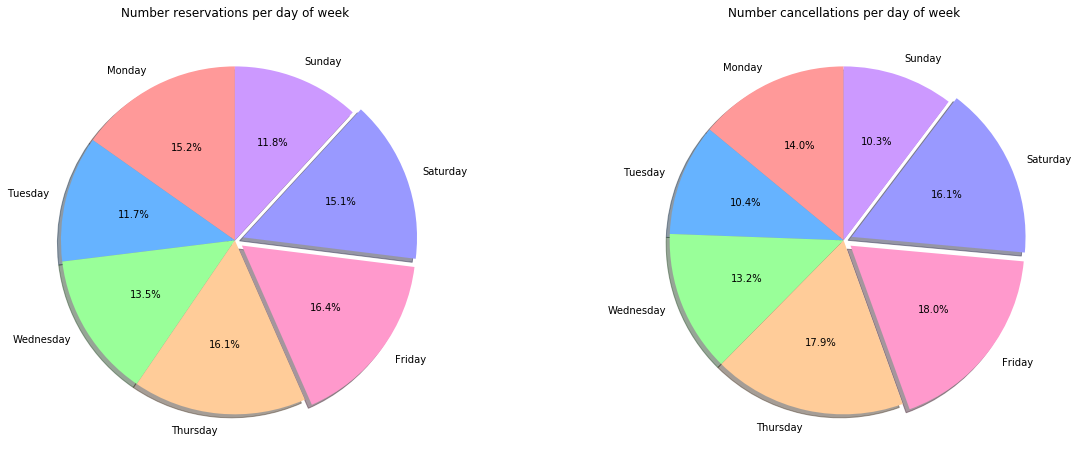

In [17]:
import warnings
import datetime as dt
from matplotlib import gridspec
warnings.filterwarnings('ignore')

df_hotel_sub = df_hotel[['arrival_weekday_num', 'adr', 'is_canceled']]
dayofweek = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_hotel_sub['weekday'] = df_hotel_sub['arrival_weekday_num'].map(dayofweek)

# draw number of reservations by day
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#ff99cc', '#9999ff', '#cc99ff']
df_hotel_sub=df_hotel_sub.sort_values('arrival_weekday_num').set_index('arrival_weekday_num')
labels = df_hotel_sub['weekday'].unique()
counts = df_hotel_sub.groupby('arrival_weekday_num').count()['weekday']

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].pie(counts, explode = (0,0,0,0,0.05,0.05,0), labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90 )
ax[0].set_title("Number reservations per day of week")
ax[0].axis('off')

# draw number of cancellations by day
df_hotel_canceled = df_hotel_sub[df_hotel_sub['is_canceled'] == 1]

labels = df_hotel_canceled['weekday'].unique()
counts = df_hotel_canceled.groupby('arrival_weekday_num').count()['weekday']

ax[1].pie(counts, explode = (0,0,0,0,0.05,0.05,0), labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90 )
ax[1].set_title("Number cancellations per day of week")
ax[1].axis('off')




As expected, there are larger number of reservations towards the weekend, specifically on __Thursday__, __Friday__ and __Sunday__. Similarly, __Cancellations__ are highest in those 3 days as well, in particular on __Friday__, immediately before the weekend starts. Therefore, we can conclude that driving feature __arrival_weekday_num__ is very important.

In [18]:
# sample read and save - will be removed after project is done
#df_hotel = pd.read_pickle('hotel_bookings_.pkl')
df_hotel.to_pickle('hotel_bookings_1.pkl')
print(df_hotel.shape)
df_hotel.to_pickle('hotel_bookings_.pkl')

(119390, 34)


<hr><hr>

### Exploration

Show columns and their data types for further analysis

In [19]:
df_hotel = pd.read_pickle('hotel_bookings_1.pkl')
df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 34 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

The above data types show that a large number of columns such as hotel, arrival_date_month, children, meal, country etc. must be converted to make sense of the data for regression analysis.

<hr><hr>
Describe distributions of each column, it will make sense for numerical columns

In [20]:
df_hotel = pd.read_pickle('hotel_bookings_1.pkl')
df_hotel.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0



<hr>

### Clean up

List sum of __NA__ values to consider replacement

In [21]:
df_hotel = pd.read_pickle('hotel_bookings_1.pkl')
print(df_hotel.isna().sum())

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Rows with empty __Country__ can be dropped since it is a very small number of rows

In [22]:
df_hotel = pd.read_pickle('hotel_bookings_1.pkl')

df_hotel=df_hotel.dropna(subset=["country"]) 

df_hotel.to_pickle('hotel_bookings_2.pkl')
df_hotel.shape

(118902, 34)

Distribution of countries by number of rows is where country contirbutes more than 100 rows:

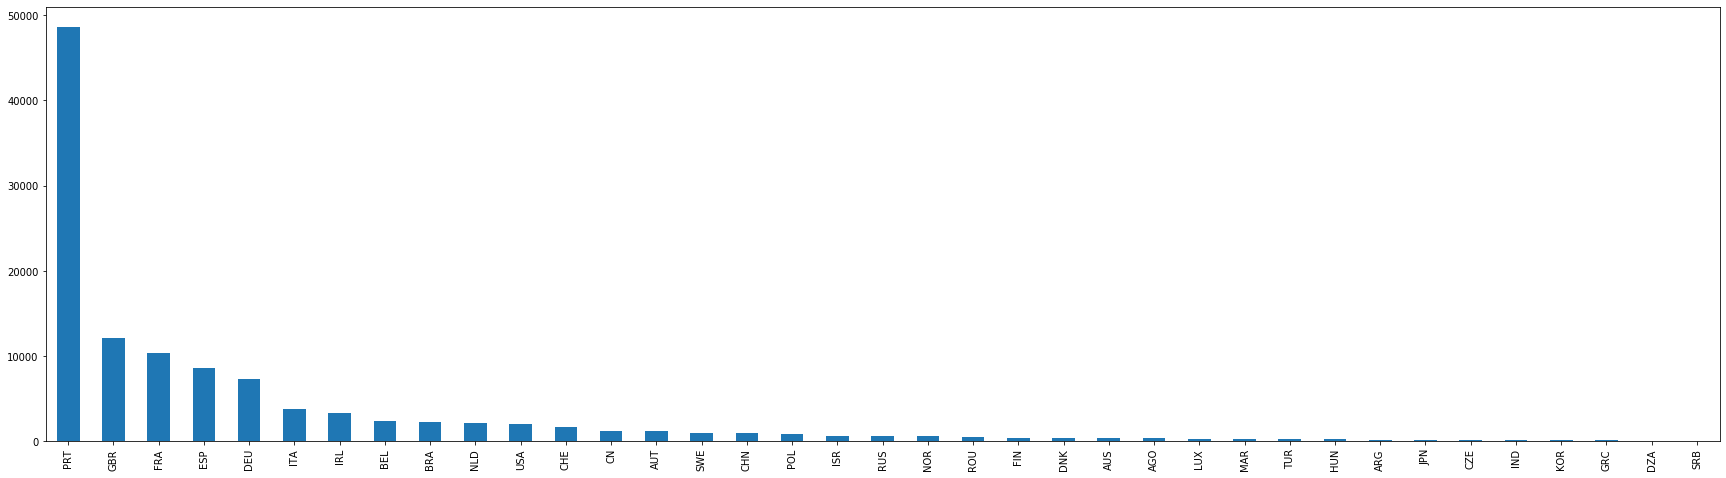

In [23]:
df_hotel = pd.read_pickle('hotel_bookings_2.pkl')
country_vc = df_hotel.country.value_counts()
country_vc[country_vc > 100].plot(kind="bar",figsize=(30, 8))

This indicates that countries that contribute less than 100 rows, contribute very little number of rows to the data compared to countries with most contribution of rows.
Therefore, it is a good idea to reduce number of countries to those with more than 100 rows, since that will give us a smaller number of countries for hot encoding.
Based on above logic, we will remove data from countries that __contirbute < 100 rows__

In [24]:
df_hotel = pd.read_pickle('hotel_bookings_2.pkl')

df_hotel = df_hotel.groupby('country').filter(lambda x: len(x) > 100)

df_hotel.to_pickle('hotel_bookings_3.pkl')

print(df_hotel.shape)
print('\nUnique countries without rows < 100: \n', df_hotel.country.unique())

(116412, 34)

Unique countries without rows < 100: 
 ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'ARG' 'POL' 'DEU' 'BEL'
 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'CZE' 'BRA' 'FIN'
 'LUX' 'IND' 'CHN' 'MAR' 'SRB' 'AUT' 'TUR' 'AGO' 'ISR' 'DZA' 'KOR' 'HUN'
 'JPN']


<hr>


__Children__ are empty in only 4 rows. Replacing them with __median__ number of children can be used to populated those __4__ rows.

In [25]:
df_hotel = pd.read_pickle('hotel_bookings_3.pkl')

df_hotel['children'].fillna(df_hotel['children'].median(),inplace=True)

df_hotel.to_pickle('hotel_bookings_4.pkl')

<hr><hr>

Customers who use __Agent__ or book through a __Company__ column may get better __Average Daily Rate__ then those who don't use them. Therefore, we will keep these columns but convert them to binary columns, filling __NA__ values with __0__ and filling it with __1__ where an agent or company is used for booking.

In [26]:
df_hotel = pd.read_pickle('hotel_bookings_4.pkl')

df_hotel.agent.fillna(0, inplace=True)
df_hotel.company.fillna(0, inplace=True)

df_hotel.loc[(df_hotel.agent > 0),'agent'] = 1
df_hotel.loc[(df_hotel.company > 0),'company'] = 1


df_hotel.to_pickle('hotel_bookings_5.pkl')

print(df_hotel.agent.unique())
print(df_hotel.company.unique())


[0. 1.]
[0. 1.]


<hr>

List __NA__ values again to ensure there is none left

In [27]:
df_hotel = pd.read_pickle('hotel_bookings_5.pkl')

print(df_hotel.isna().sum())

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

<hr>

(-1.25, 1.25, -1.25, 1.25)

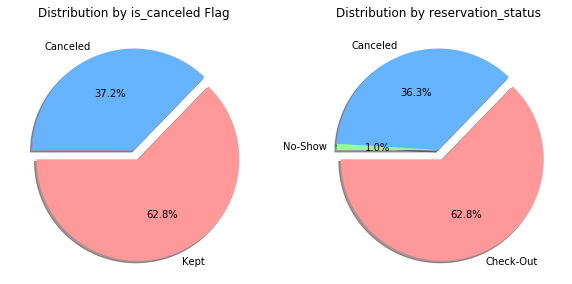

In [28]:
df_hotel = pd.read_pickle('hotel_bookings_5.pkl')

df_canceled = pd.DataFrame(df_hotel.is_canceled.value_counts())
df_canceled["label"] = df_canceled.index.map({0: "Kept", 1: "Canceled"})
df_status = pd.DataFrame(df_hotel.reservation_status.value_counts())

colors = ['#ff9999','#66b3ff','#99ff99']

fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].pie(df_canceled['is_canceled'], explode = (0.1,0), labels=df_canceled['label'], colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=180 )
ax[0].set_title("Distribution by is_canceled Flag")
ax[0].axis('off')

ax[1].pie(df_status['reservation_status'], explode = (0.1,0,0), labels=df_status.index, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=180 )
ax[1].set_title("Distribution by reservation_status")
ax[1].axis('off')

From above analysis, it is clear that is_cancelled is a derived column from reservation_status. __is_canceled 1__ is the combined total of __cancelled__ and __no-show__ statuses. Therefore, we can drop __reservation_status__ to eliminate bias when classifying __is_canceled__.

In [29]:
df_hotel = pd.read_pickle('hotel_bookings_5.pkl')

df_hotel[['arrival_date_year','arrival_date_week_number','reservation_status_date', 'adr']].corr()

,arrival_date_year,arrival_date_week_number,adr
arrival_date_year,1.000000,-0.541712,0.195661
arrival_date_week_number,-0.541712,1.000000,0.076503
adr,0.195661,0.076503,1.000000


Our target variable is __adr (Average Daily Rate)__, since __arrival_date_year__ and __arrival_date_week_number__ have near zero correlation , they will not proide  __adr__, therefore, we can drop these 2 columns.

Similarly, __reservation_status_date__ also have incremental value distributed over all of our data, hence they can't provide any predictive value and can be dropped.

In [30]:
df_hotel = pd.read_pickle('hotel_bookings_5.pkl')

df_hotel = df_hotel.drop(['arrival_date_year','arrival_date_week_number','reservation_status_date', 'reservation_status'],axis=1)

df_hotel.to_pickle('hotel_bookings_6.pkl')

<hr>

### Remove Outliers

Draw box plots of columns with continuous variables to remove outliers.

In [31]:
df_hotel = pd.read_pickle('hotel_bookings_6.pkl')
df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116412 entries, 0 to 119389
Data columns (total 30 columns):
hotel                             116412 non-null object
is_canceled                       116412 non-null int64
lead_time                         116412 non-null int64
arrival_date_month                116412 non-null object
arrival_date_day_of_month         116412 non-null int64
stays_in_weekend_nights           116412 non-null int64
stays_in_week_nights              116412 non-null int64
adults                            116412 non-null int64
children                          116412 non-null float64
babies                            116412 non-null int64
meal                              116412 non-null object
country                           116412 non-null object
market_segment                    116412 non-null object
distribution_channel              116412 non-null object
is_repeated_guest                 116412 non-null int64
previous_cancellations            116412 

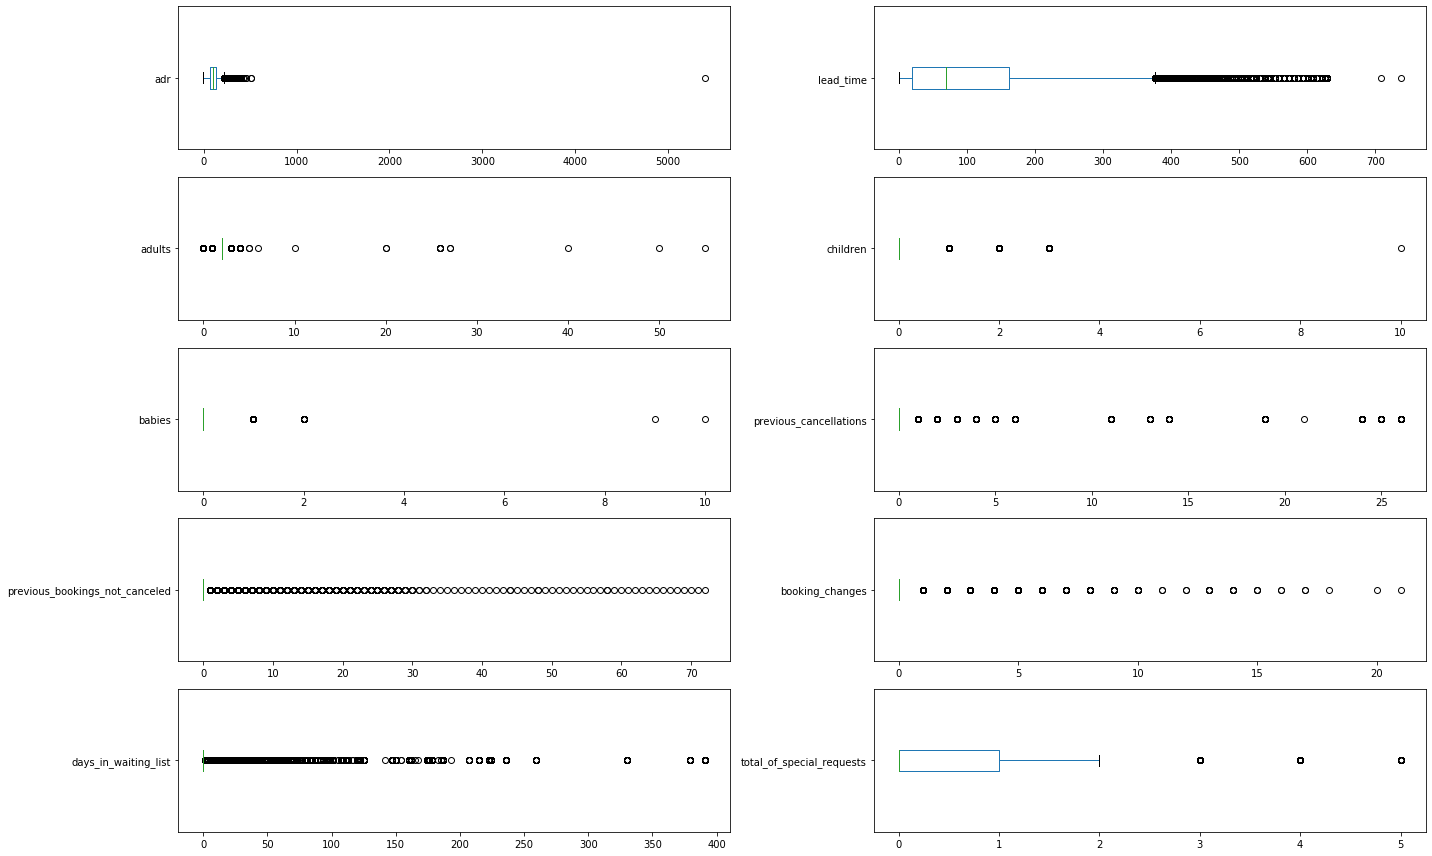

In [32]:
df_hotel = pd.read_pickle('hotel_bookings_6.pkl')

df_hotel_cont = df_hotel[['adr', 'lead_time', 'adults', 'children', 'babies', 'previous_cancellations'
                            , 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'total_of_special_requests']]

plt.figure(figsize=(20,12))
for col in df_hotel_cont.columns:
    plt.subplot(5,2,df_hotel_cont.columns.get_loc(col) + 1)
    df_hotel[col].plot.box(vert=False)
    plt.tight_layout()

We notice that there is a single outlier value of __adr__ column within upper quantile, that must be removed to unskew the data.
Similarly rest of the colmns have outliers as well.
Since we have large amount of data (~120K rows), we will use Q1-1.5IQR and Q3+1.5IQR as outlier boundaries for each continuous column to eliminate outliers.

In [33]:
df_hotel = pd.read_pickle('hotel_bookings_6.pkl')
df_hotel_cont = df_hotel[['adr', 'lead_time', 'adults', 'children', 'babies', 'previous_cancellations'
                            , 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'total_of_special_requests']]

for col in df_hotel_cont.columns:

    Q1 = df_hotel[col].quantile(0.25)
    Q3 = df_hotel[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = (Q1 - 1.5 * IQR)
    upper_bound = (Q3 + 1.5 * IQR)
    if lower_bound != upper_bound :
        df_hotel = df_hotel[(df_hotel[col] > lower_bound ) & (df_hotel[col] < upper_bound)]


df_hotel.to_pickle('hotel_bookings_7.pkl')

df_hotel.shape


(107387, 30)

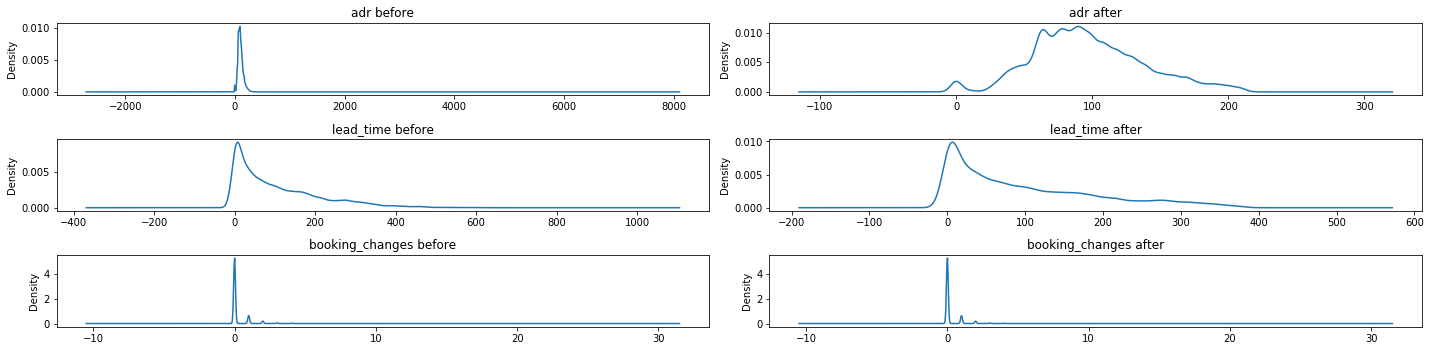

In [34]:
df_hotel_with_outliers = pd.read_pickle('hotel_bookings_6.pkl')
df_hotel_without_outliers = pd.read_pickle('hotel_bookings_7.pkl')

continuous_cols = ['adr', 'lead_time', 'adults', 'children', 'babies', 'previous_cancellations'
                            , 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'total_of_special_requests']

df_before = df_hotel_with_outliers[continuous_cols]
df_after = df_hotel_without_outliers[continuous_cols]

plt.figure(figsize=(20,16))
n = 1
for col in ['adr', 'lead_time', 'booking_changes']:
    plt.subplot(10,2, n)
    ax = df_before[col].plot.kde()
    ax.set_title(col + ' before')
    plt.subplot(10,2, n + 1)
    ax = df_after[col].plot.kde()
    ax.set_title(col + ' after')
    n = n + 2
plt.tight_layout()
    


As we can observe above, after removing outliers, __adr__, __lead_time__, and __booking_changes__ have smoother density curves 

<hr>

Analysis of __adr (Average Daily Rate)__ based on month.
It should reveal relationship between month of the year and adr flucatuation.

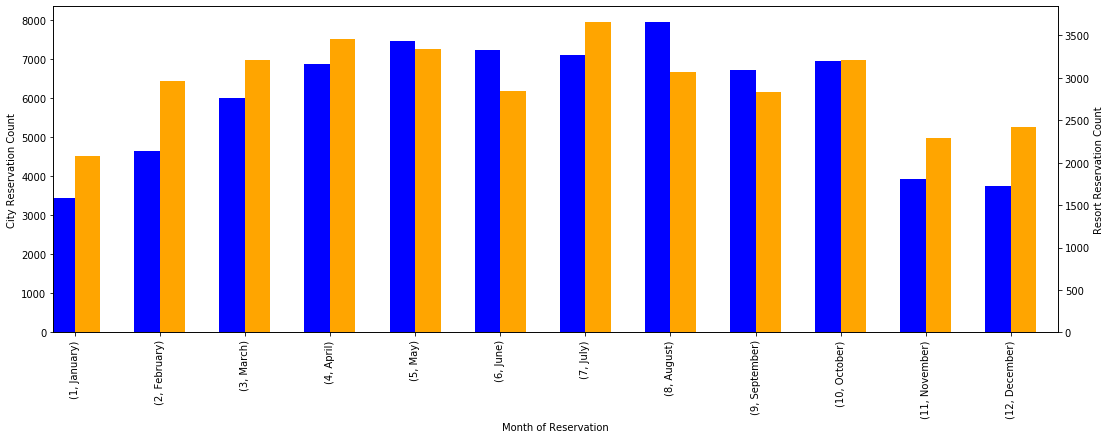

In [35]:
df_hotel = pd.read_pickle('hotel_bookings_7.pkl')

df_hotel['arrival_date_month_number'] = df_hotel['arrival_date_month'].apply(lambda x: datetime.datetime.strptime(x, "%B").month)

df_city = df_hotel[df_hotel['hotel'] == 'City Hotel']
df_resort = df_hotel[df_hotel['hotel'] == 'Resort Hotel']

city_counts = df_city.groupby(['arrival_date_month_number', 'arrival_date_month'])['adr'].count()
resort_counts = df_resort.groupby(['arrival_date_month_number', 'arrival_date_month'])['adr'].count()


city_adr = df_city.groupby(['arrival_date_month_number', 'arrival_date_month'])['adr'].sum()
resort_adr = df_resort.groupby(['arrival_date_month_number', 'arrival_date_month'])['adr'].sum()

labels = city_counts.index.get_level_values('arrival_date_month')

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111) 
ax2 = ax.twinx() 
city_counts[:].plot(kind='bar', color='blue', ax=ax, width=0.3, position=1)
resort_counts[:].plot(kind='bar', color='orange', ax=ax2, width=0.3, position=0)
ax.set_xlabel('Month of Reservation')
ax.set_ylabel('City Reservation Count')
ax2.set_ylabel('Resort Reservation Count')
plt.show()




This graph above shows distribution of __City__ vs __Resort__ reservation count for each month of the year.
We notice that Resort is booked more than City hotel in winter months, whereas, both hotels have somewhat equal reservations in the summer months.

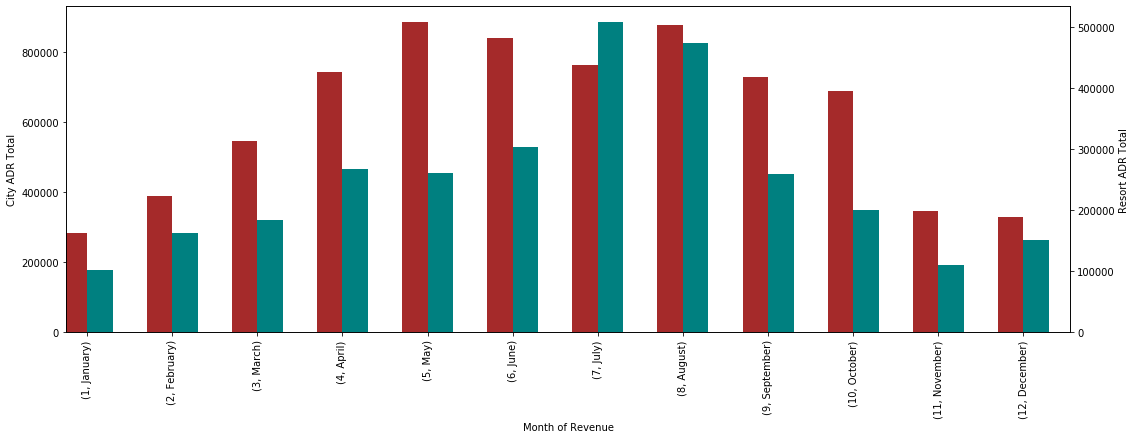

In [36]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111) 
ax2 = ax.twinx() 
city_adr[:].plot(kind='bar', color='brown', ax=ax, width=0.3, position=1)
resort_adr[:].plot(kind='bar', color='teal', ax=ax2, width=0.3, position=0)
ax.set_xlabel('Month of Revenue')
ax.set_ylabel('City ADR Total')
ax2.set_ylabel('Resort ADR Total')
plt.show()

The above graph reveals that even though __City Hotel__ books less frequently than __Resort Hotel__, its ADR total is __higher__ than Resort Hotel.
Overall, the previous two histograms show a correlation between type of hote, month of reservation and __adr__ amount.

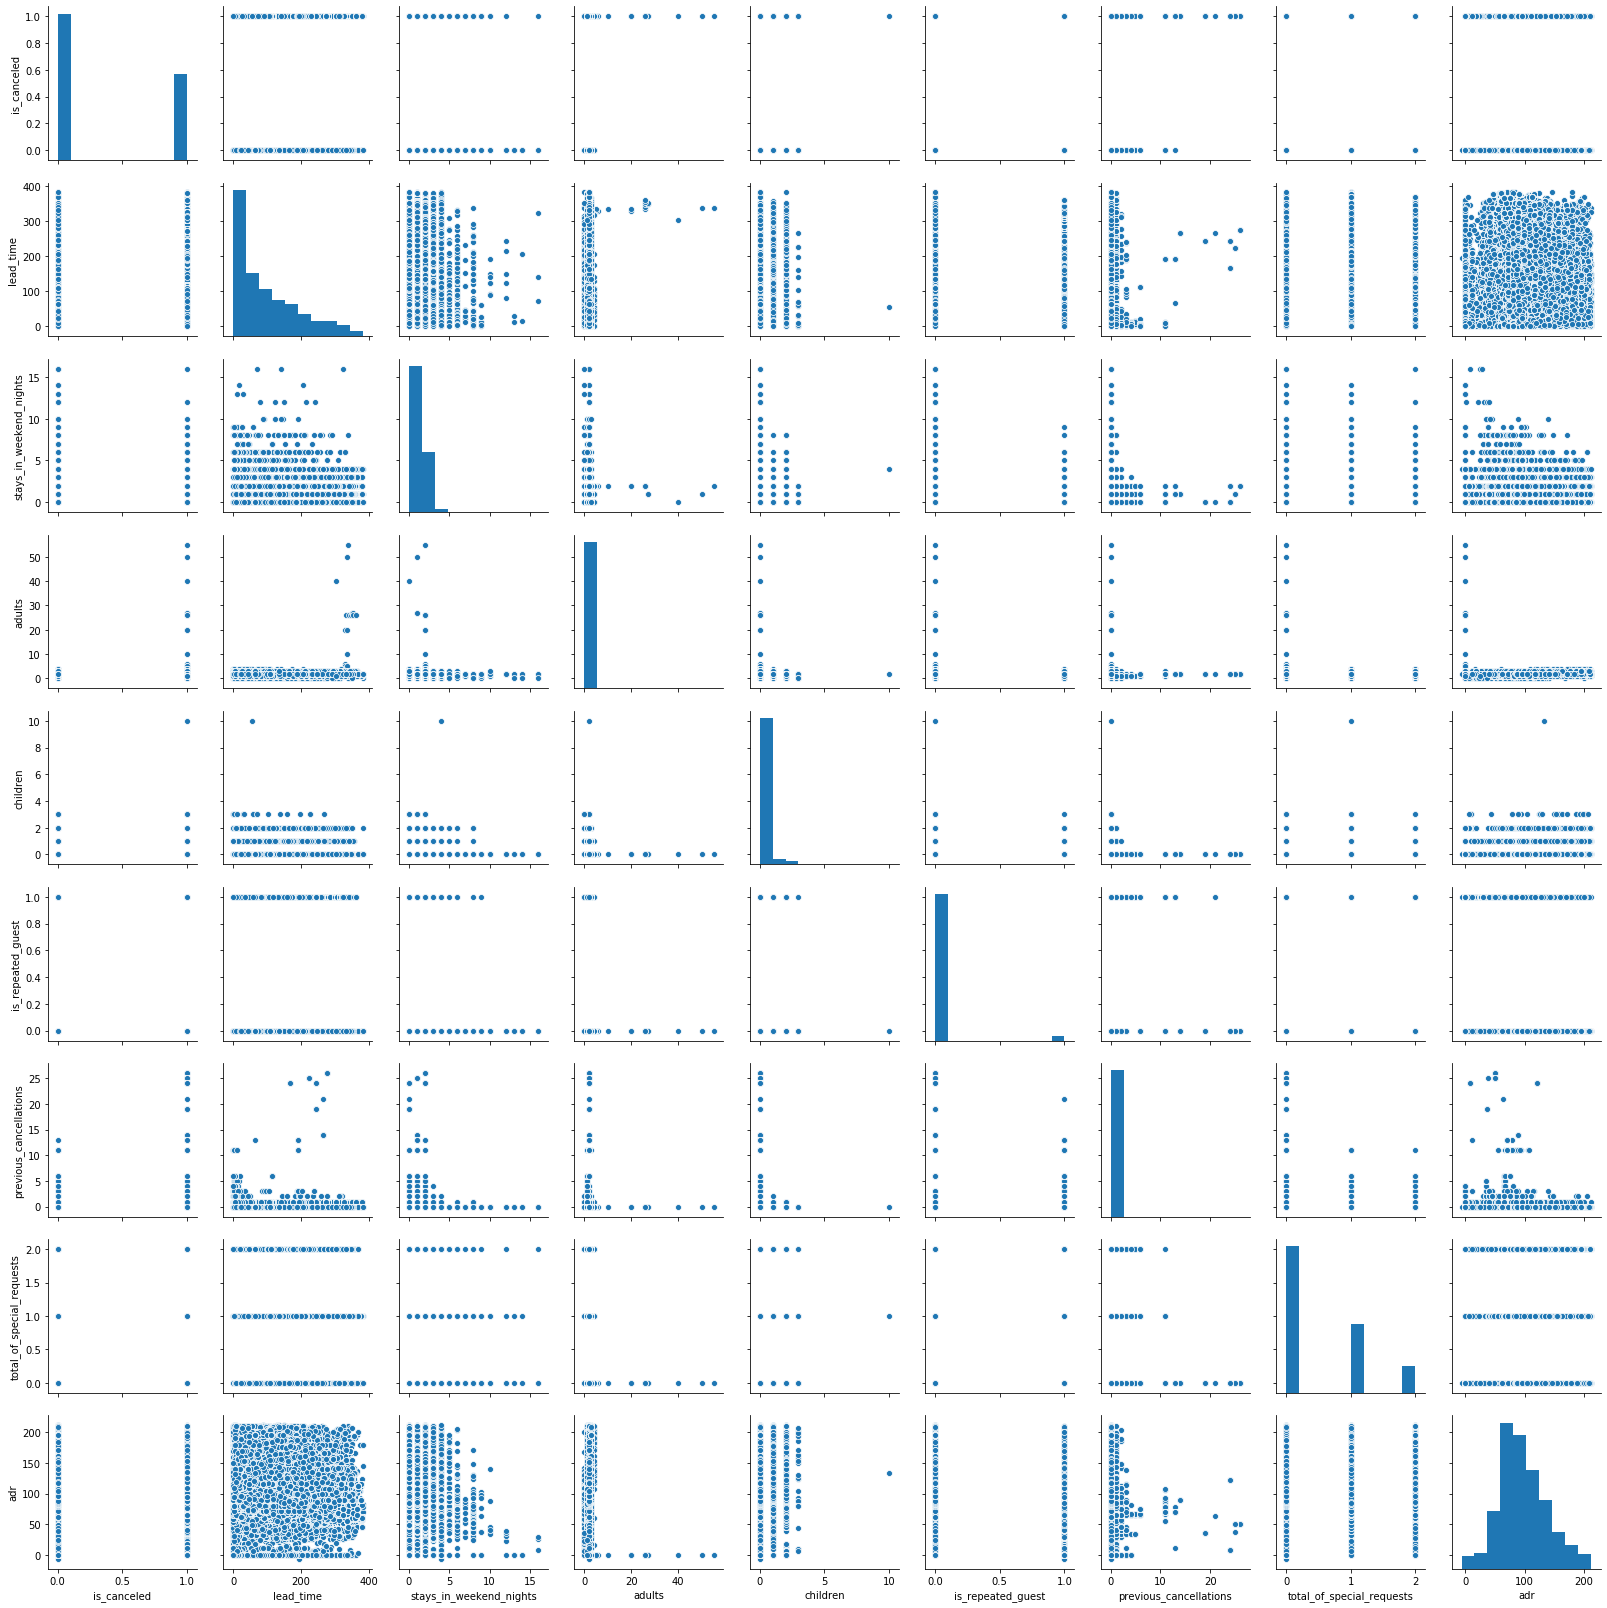

In [37]:
import seaborn as sns
df_hotel = pd.read_pickle('hotel_bookings_7.pkl')

sns.pairplot(df_hotel[['hotel', 'is_canceled', 'lead_time', 'arrival_date_month', 'stays_in_weekend_nights', 'adults', 'children',
                      'meal', 'market_segment', 'is_repeated_guest', 'previous_cancellations', 'reserved_room_type',
                      'total_of_special_requests', 'adr']])

PairPlot above shows distribution for categorical features and correlation for continuous features.
There are some interesting trends revealed by this graph.
- For example, __leadtime__ doesnt explain any variance in __adr__ or __is_canceled__.
- People who have high __previous_cancellations__ are likely to have cancellation __is_canceled__ checked.
- Most of the featurs contribute little towards __adr__, not strongly correlated feature exists.
- More number of __adults__ means higher likelyhood of cancellation __is_canceled__ checed.

<hr>

### Correlation Heatmap

Create correlation heatmap to find stronger correlation between various columns. It should indicate which features have strong positive or negative correlation with __adr__

(14.0, 0.0)

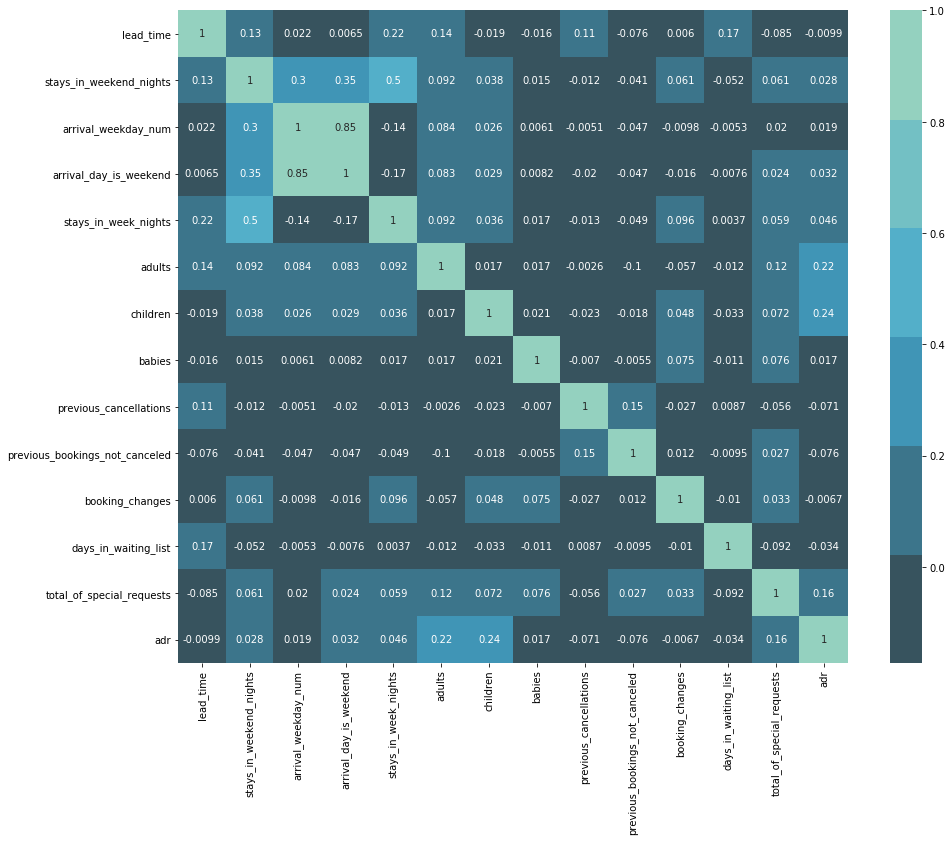

In [38]:
df_hotel = pd.read_pickle('hotel_bookings_7.pkl')

import seaborn as sns

df_hotel_cont = df_hotel[['lead_time', 'stays_in_weekend_nights','arrival_weekday_num','arrival_day_is_weekend', 
                          'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations'
                           , 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
                           'total_of_special_requests', 'adr']]

fig, ax = plt.subplots(figsize=(15,12))
cmap = sns.color_palette("GnBu_d")
sns.heatmap(df_hotel_cont.corr(), ax = ax, annot= True, cmap=cmap)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

From the heatmap, it is clear that __adr__ has higher correlation with number of __adults and children__, __total number of special requests__ and to a lesser degree, it is correlated with __weekend arrivals__ and __reservations__ as well. __light blue__ and __teal__ color shows correlation in the map, while __darker__ regions havevery few or negative correlation.

<hr>

<hr>

One-hot encode the following columns so that they can be plotted/used for regression analysis.

> - __hotel__
> - __country__
> - __market_segment__
> - __arrival_date_month__
> - __meal__
> - __deposit_type__
> - __distribution_channel__
> - __reserved_room_type__
> - __assigned_room_type__
> - __customer_type__

In [40]:
df_hotel = pd.read_pickle('hotel_bookings_7.pkl')

categorical_cols = ['hotel', 'country', 'market_segment', 'arrival_date_month','meal','deposit_type',
                    'distribution_channel','reserved_room_type',
                    'assigned_room_type', 'customer_type']

df_hotel = pd.get_dummies(data=df_hotel, columns = categorical_cols)

df_hotel.get_dtype_counts()

df_hotel.to_pickle('hotel_bookings_8.pkl')

print(df_hotel.shape)
df_hotel.dtypes.value_counts()

(107387, 118)


uint8      98
int64      16
float64     4
dtype: int64

<hr>

### Normalization

First we will decide whether to use __Standardization__ or __Normalization__.

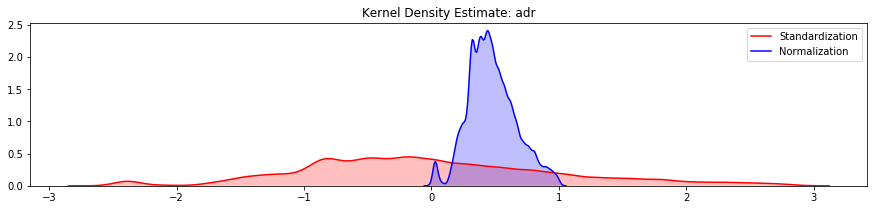

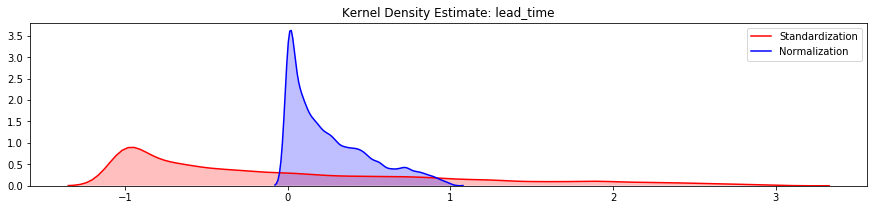

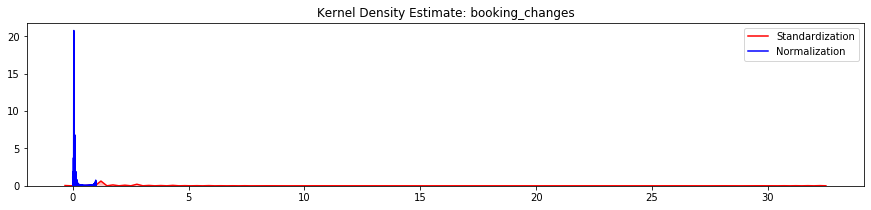

In [41]:
import seaborn as sns

df_hotel = pd.read_pickle('hotel_bookings_8.pkl')

continuous_cols = ['adr', 'lead_time', 'adults', 'children', 'babies', 'previous_cancellations'
                            , 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'total_of_special_requests']


df_hotel_num = df_hotel[continuous_cols]

standardizer = StandardScaler()
normalizer = MinMaxScaler()

X_hotel_num_std = pd.DataFrame(standardizer.fit_transform(df_hotel_num), columns = df_hotel_num.columns)
X_hotel_num_norm = pd.DataFrame(normalizer.fit_transform(df_hotel_num), columns = df_hotel_num.columns)

for col in ['adr', 'lead_time', 'booking_changes']:
    f, ax = plt.subplots(figsize=(15, 3))
    plt.title("Kernel Density Estimate: " + col)
    p1=sns.kdeplot(X_hotel_num_std[col], shade=True, color="r", label='Standardization')
    p2=sns.kdeplot(X_hotel_num_norm[col], shade=True, color="b", label='Normalization')
    plt.show()
p1


In the above density diagrams, Standardized scaler spreads values between negative and positive values along horizontal axis where we can still see __booking_changes__ values much larger than __adr__ and __lead_time__, however, Noramlization (MinMaxScaler) distributes values between 0 and 1. Since we are dealing with number of adults, children, rooms, cancellations and amounts, it makes sense to user MinMaxScaler instead of Standard scaler.

Therefore, performing normalization and resaving data.

In [42]:
df_hotel = pd.read_pickle('hotel_bookings_8.pkl')

y=df_hotel.pop('adr')

X_train, X_test, y_train, y_test = train_test_split(df_hotel, y, test_size=0.3,random_state=42)
print(f"Train with {X_train.shape[0]} samples and test with {X_test.shape[0]} samples.")

num_attribs = list(df_hotel) # list all the numeric features

normalizer = MinMaxScaler()

X_train_norm = normalizer.fit_transform(X_train)

X_test_norm = normalizer.transform(X_test)

#X_train_norm.desc

X_train_norm=pd.DataFrame(X_train_norm,columns=X_train.columns)
X_test_norm =pd.DataFrame(X_test_norm,columns=X_test.columns)


X_train_norm.to_pickle('X_train_norm_reg.pkl')
X_test_norm.to_pickle('X_test_norm_reg.pkl')
y_train.to_pickle('y_train_reg.pkl')
y_test.to_pickle('y_test_reg.pkl')


Train with 75170 samples and test with 32217 samples.


### Feature Selection & Reduction

Here we will use various technique to reduce our feature set to a smaller number of features.
It can be either accomplished by eliminating some columns by ranking them by importance of those features, or it can be accomplished by combining features into others .e.g via PCA

### Recursive Feature Elimination with Cross-Validation (RFECV)
We used RFECV to get optimal set of features with cross-validation and tried them with various analysis models. However, we found out that for our dataset, feature elimination using this mechanism gave us poorer results than __KBest__ and __PCA__ method of feature reduction.

Optimal number of features : 93


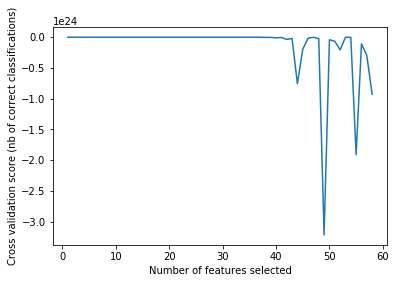

In [43]:
#Feature Selection
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

X_train_norm=pd.read_pickle('X_train_norm_reg.pkl')

modelX = LinearRegression()
rfecv = RFECV(estimator=modelX, step=1, scoring='neg_mean_squared_error',  min_features_to_select=60)
rfecv.fit(X_train_norm, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


Text(0.5, 0, 'dimensions')

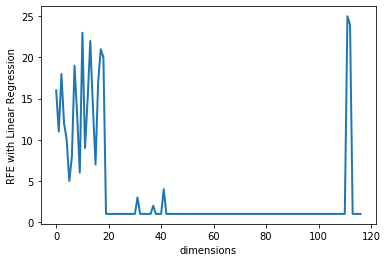

In [44]:
plt.plot(rfecv.ranking_, linewidth=2)
plt.ylabel('RFE with Linear Regression')
plt.xlabel('dimensions')

In [45]:
print(rfecv.grid_scores_)

[-1.06053976e+03 -1.06003760e+03 -1.05718099e+03 -1.05673955e+03
 -1.05466915e+03 -1.05427905e+03 -1.05115251e+03 -1.05039448e+03
 -1.04970723e+03 -1.04968272e+03 -1.04912481e+03 -1.04548719e+03
 -1.04268322e+03 -1.04200605e+03 -1.00205620e+03 -1.00154228e+03
 -9.91332921e+02 -9.76658529e+02 -9.66741371e+02 -9.54081660e+02
 -9.34522386e+02 -9.25404345e+02 -9.18327175e+02 -9.16543383e+02
 -9.14137667e+02 -9.13665278e+02 -8.81763214e+02 -8.82064059e+02
 -8.56734450e+02 -8.27015967e+02 -8.08878200e+02 -8.06254608e+02
 -8.04415976e+02 -7.95225667e+02 -3.30227264e+18 -1.65988874e+18
 -4.51685802e+20 -2.13637201e+21 -2.50932060e+21 -8.93448628e+21
 -4.62655858e+21 -3.46560507e+22 -2.14498876e+22 -7.55444459e+23
 -1.97456218e+23 -1.64435220e+22 -6.16503424e+20 -2.44774528e+22
 -3.21563500e+24 -4.21342887e+22 -6.48412379e+22 -2.05963401e+23
 -5.28673251e+20 -1.21063494e+21 -1.91240738e+24 -1.07787548e+23
 -2.97138535e+23 -9.27582713e+23]


In [46]:
print (rfecv.ranking_)

[16 11 18 12 10  5  8 19 13  6 23  9 15 22 14  7 17 21 20  1  1  1  1  1
  1  1  1  1  1  1  1  3  1  1  1  1  1  2  1  1  1  4  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 25 24  1  1  1  1]


In [47]:
print (rfecv.support_)

[False False False False False False False False False False False False
 False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True False  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False  True  True  True  True]


In [48]:
f = rfecv.get_support(1) #the most important features
X = X_train_norm[X_train_norm.columns[f]]# final features`
X.head()
rfecv_columns = X.columns
rfecv_columns

Index(['hotel_City Hotel', 'hotel_Resort Hotel', 'country_AGO', 'country_ARG',
       'country_AUS', 'country_AUT', 'country_BEL', 'country_BRA',
       'country_CHE', 'country_CHN', 'country_CN', 'country_CZE',
       'country_DNK', 'country_DZA', 'country_ESP', 'country_FIN',
       'country_FRA', 'country_GRC', 'country_HUN', 'country_IND',
       'country_ISR', 'country_ITA', 'country_JPN', 'country_KOR',
       'country_LUX', 'country_MAR', 'country_NLD', 'country_NOR',
       'country_POL', 'country_PRT', 'country_ROU', 'country_RUS',
       'country_SRB', 'country_SWE', 'country_TUR', 'country_USA',
       'market_segment_Aviation', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'market_segment_Undefined',
       'arrival_date_month_April', 'arrival_date_month_August',
       'arrival_date_month_December', 'arrival_date_month_February',


### Principle Component Analysis (PCA)

In [49]:
from sklearn.decomposition import PCA

X_train_norm=pd.read_pickle('X_train_norm_reg.pkl')

pca = PCA(n_components=117)

X_train_norm_decomposed = pca.fit_transform(X_train_norm)



In [50]:
cumulsum = np.cumsum(pca.explained_variance_ratio_)
print(cumulsum)

[0.12332948 0.22127445 0.28891521 0.3525052  0.41260986 0.46426708
 0.50251107 0.53874192 0.5679297  0.59307387 0.61522713 0.63588565
 0.65293913 0.66960852 0.68572782 0.70138158 0.71670316 0.73169684
 0.74641216 0.76090096 0.77466095 0.78780555 0.80092886 0.8132362
 0.82463815 0.83529232 0.84565642 0.85543677 0.86473838 0.87377363
 0.88250491 0.89096705 0.8984948  0.90593531 0.91275227 0.91814613
 0.92324931 0.92799702 0.93235356 0.93636495 0.94032392 0.94375907
 0.94716849 0.95037584 0.95348212 0.95639932 0.95908893 0.96157631
 0.96404689 0.96642804 0.96846538 0.97049898 0.97229856 0.97405575
 0.97572096 0.97725224 0.97864906 0.98000568 0.981316   0.98251647
 0.9835539  0.98458266 0.98559601 0.9865472  0.98743989 0.98830699
 0.98902495 0.98973388 0.99038103 0.99101267 0.99163176 0.99224118
 0.99280328 0.99333301 0.99381491 0.99428083 0.99471083 0.9951112
 0.99548342 0.99584072 0.99619042 0.99652541 0.99685727 0.9971825
 0.99749712 0.99780406 0.99810181 0.99832924 0.99854501 0.9987367

In [51]:
np.sum(pca.explained_variance_ratio_)

1.0

Text(0.5, 0, 'dimensions')

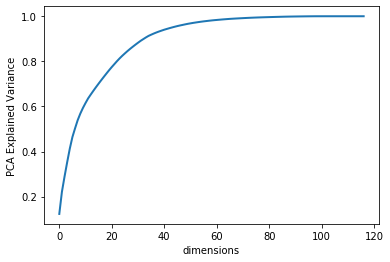

In [52]:
plt.plot(cumulsum, linewidth=2)
plt.ylabel('PCA Explained Variance')
plt.xlabel('dimensions')

Based on the vairance explained by PCA components, lets apply 70 compnents based on the cumulative curve.

In [53]:
X_train_norm=pd.read_pickle('X_train_norm_reg.pkl')

for nc in [50,55,60,65,70]:
    pca = PCA(n_components=nc)
    X_train_norm_decomposed = pca.fit_transform(X_train_norm)
    print('Variance explained by ' , nc, ' components: ', np.sum(pca.explained_variance_ratio_))

Variance explained by  50  components:  0.9664159194070615
Variance explained by  55  components:  0.975718362766853
Variance explained by  60  components:  0.9825141325249411
Variance explained by  65  components:  0.9874376364800003
Variance explained by  70  components:  0.991009078134203


Since the explained variance changes only by 3rd decimal place for components greater than 60, we choose __60__ as selected number of components

In [54]:
X_train_norm=pd.read_pickle('X_train_norm_reg.pkl')

pca = PCA(n_components=60)

X_train_norm_decomposed = pca.fit_transform(X_train_norm)


In [55]:
X_test_norm = pd.read_pickle('X_test_norm_reg.pkl')

X_test_norm_decomposed = pca.transform(X_test_norm)

X_test_norm_decomposed.shape

(32217, 60)

In [56]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

y_train = pd.read_pickle('y_train_reg.pkl')

#Convert datatypes
y_train_int = y_train.astype(int)

selector = SelectKBest(chi2, k=60)
selector.fit(X_train_norm, y_train_int)

#  get the list
col_names = list(df_hotel.columns[selector.get_support(indices=True)])


X_train_norm_kbest = X_train_norm[col_names]
X_test_norm_kbest = X_test_norm[col_names]

X_train_norm_kbest.to_pickle('X_train_norm_reg_kbest.pkl')
X_test_norm_kbest.to_pickle('X_test_norm_reg_kbest.pkl')

X_train_norm_kbest.head(5)

,is_canceled,lead_time,children,is_repeated_guest,previous_cancellations,company,total_of_special_requests,hotel_City Hotel,hotel_Resort Hotel,country_DEU,...,assigned_room_type_A,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_I,assigned_room_type_K,customer_type_Contract,customer_type_Transient,customer_type_Transient-Party
0,0.0,0.015748,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.585302,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.136483,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.002625,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.939633,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Prepare Classification Data - (is_cancelled)

We prepare data with similar steps to regression data, but only applying __PCA__ and __KBest__ to reduce the dataset.

In [57]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

df_hotel = pd.read_pickle('hotel_bookings_8.pkl')

y=df_hotel.pop('is_canceled')

X_train, X_test, y_train, y_test = train_test_split(df_hotel, y, test_size=0.3,random_state=42)
print(f"Train with {X_train.shape[0]} samples and test with {X_test.shape[0]} samples.")



Train with 75170 samples and test with 32217 samples.


__Normalization__

In [58]:

normalizer = MinMaxScaler()

X_train_norm = normalizer.fit_transform(X_train)

X_test_norm = normalizer.transform(X_test)

#X_train_norm.desc

X_train_norm=pd.DataFrame(X_train_norm,columns=X_train.columns)
X_test_norm =pd.DataFrame(X_test_norm,columns=X_test.columns)

X_train_norm.to_pickle('X_train_norm_clf.pkl')
X_test_norm.to_pickle('X_test_norm_clf.pkl')
y_train.to_pickle('y_train_clf.pkl')
y_test.to_pickle('y_test_clf.pkl')

y_train.head()

105900    0
6066      0
62430     1
89326     0
53785     1
Name: is_canceled, dtype: int64

### Principal Component Analysis (PCA)

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=117)

X_train_norm_decomposed = pca.fit_transform(X_train_norm)

In [60]:

for nc in [50,55,60,65,70]:
    pca = PCA(n_components=nc)
    X_train_norm_decomposed = pca.fit_transform(X_train_norm)
    print('Variance explained by ' , nc, ' components: ', np.sum(pca.explained_variance_ratio_))

Variance explained by  50  components:  0.965657796201521
Variance explained by  55  components:  0.9749851064277957
Variance explained by  60  components:  0.9820157400021464
Variance explained by  65  components:  0.9870348864250152
Variance explained by  70  components:  0.9907201292430563


In [61]:
pca = PCA(n_components=70)
X_train_norm_decomposed = pca.fit_transform(X_train_norm)
X_test_norm_decomposed = pca.transform(X_test_norm)

X_train_norm_decomposed=pd.DataFrame(X_train_norm_decomposed)
X_test_norm_decomposed =pd.DataFrame(X_test_norm_decomposed)

X_train_norm_decomposed.to_pickle('X_train_norm_clf_pca.pkl')
X_test_norm_decomposed.to_pickle('X_test_norm_clf_pca.pkl')

### Select K-Best

In [63]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
y_train_int = y_train.astype(int)
selector = SelectKBest(chi2, k=60)
selector.fit(X_train_norm, y_train_int)

col_names = list(df_hotel.columns[selector.get_support(indices=True)])

X_train_norm_filtered = X_train_norm[col_names]
X_test_norm_filtered = X_test_norm[col_names]
col_names

['lead_time',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'hotel_City Hotel',
 'hotel_Resort Hotel',
 'country_AGO',
 'country_AUT',
 'country_BEL',
 'country_CHE',
 'country_CN',
 'country_DEU',
 'country_ESP',
 'country_FIN',
 'country_FRA',
 'country_GBR',
 'country_IRL',
 'country_NLD',
 'country_POL',
 'country_PRT',
 'country_SWE',
 'country_USA',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'arrival_date_month_April',
 'arrival_date_month_January',
 'arrival_date_month_June',
 'arrival_date_month_March',
 'arrival_date_month_November',
 'meal_FB',
 'meal_Undefined',
 'deposit_type_No Deposit',
 'deposit_type_Non Refund',
 'distribution_channel_Corporate',
 'distribution_channel_Direct',
 'distribution_channel_TA/TO',
 'reserved_room_type_A',
 